In [2]:
import pandas as pd
import numpy as np

In [3]:
import re

In [4]:
import matplotlib
import matplotlib.pyplot as plt

In [5]:
from datetime import datetime
from difflib import get_close_matches

In [6]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV


from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import svm

from sklearn.metrics import f1_score

In [7]:
from xgboost import XGBClassifier, XGBRegressor, plot_importance

In [8]:
from sklearn.utils import shuffle

In [9]:
# BTCUSD_1H = pd.read_csv('../data/Binance_BTCUSDT_1h.csv', skiprows=1)

In [10]:
df_ETHUSD_1min = pd.read_parquet('../ETH-USDT.parquet')

In [11]:
df_ETHUSD_1min = df_ETHUSD_1min[df_ETHUSD_1min['volume'] != 0]

In [12]:
df_ETHUSD_1min.loc['2017-09-12 06:10:00']

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
open_time,,,,,,,,,
2017-09-12 06:10:00,309.779999,309.779999,309.779999,309.779999,0.40098,124.215584,4,0.0,0.0


In [13]:
# df_ETHUSD_1min['volume'] = df_ETHUSD_1min['volume'] + 1

In [14]:
# df_ETHUSD_1min['volume'] = np.clip(df_ETHUSD_1min['volume'], 1, df_ETHUSD_1min['volume'].max()) ??

In [15]:
df_ETHUSD_1min = df_ETHUSD_1min.sort_index(ascending=True)

In [16]:
# df_ETHUSD_1min['avg'] = df_ETHUSD_1min['quote_asset_volume']/df_ETHUSD_1min['volume']

low and high are different for different rolling averages, therefore, there should be 2 segment-paris (or 4 segments for):

> bull low v ra <br/> bull high v ra <br/> bear low v ra <br/>  bear high v ra
    
    
e.g. in a bull market, low ticker vs rolling average of X (this X needs to be found)
(expect abs(low-ra | bull) < abs(low-ra | bear)  :: absolute value of low minus ra give bull => abs(low-ra | bull)

In [17]:
# df_ETHUSD_1min.drop(['volume',
#              'quote_asset_volume',
#              'number_of_trades',
#              'taker_buy_base_asset_volume',
#              'taker_buy_quote_asset_volume'],
#             axis = 1,
# #             inplace=True
#                    )

In [18]:
agg_grouping = {'open':'first',
                'high':'max',
                'low':'min',
                'close':'last',
                'volume':'sum',
                'quote_asset_volume':'sum',
                'open_time':['min','max','count']
               }


In [19]:
def open_time_refine(txt):
    if txt[0] != 'open_time':
        return txt[0]
    
    else:
        return txt[0] + '_' +txt[1]

In [20]:
def window_groupby(df, grouper_key, freq, agg_grouping):
    
    df_temp = df.reset_index().groupby(pd.Grouper(key=grouper_key, freq=freq)).agg(agg_grouping)
    
    if 'open_time' in agg_grouping.keys():
        df_temp.columns = [open_time_refine(col) for col in df_temp.columns]
    
    df_temp['avg'] = df_temp['quote_asset_volume']/df_temp['volume']
    
    return df_temp

In [21]:
df_15min = window_groupby(df=df_ETHUSD_1min,
                       grouper_key='open_time',
                       freq='15min',
                       agg_grouping=agg_grouping
                         )

In [22]:
def add_rolling_averges(df, list_to_add_unit_hour, index_unit):
    """
    INPUT:
    df - dataframe (assume the datafram is already sorted)
    list_to_add_unit_hour - list of rolling averages to add in the unit of hour, e.g.
                            list_to_add_unit_hour = [1, 2, 4] , will produce R.As of
                            1H, 2H, 4H (window calculated by dividing by the index_unit)
                            
    index_unit - unit of index (whatever was used in the grouper), e.g. '15min' (takes minutes)
    
    OUTPUT:
    dataframe with added rolling averages
    """
    df_temp = df
    
    rows = float(index_unit.replace('min',''))/60
    
    for ra in list_to_add_unit_hour:
        
        df_temp['ra_{x}H'.format(x=ra)] = df_temp['avg'].rolling(window=int(ra/rows)).mean()
    
    return df_temp

In [23]:
df_prepare = add_rolling_averges(df_15min, [1,2,4], '15min').dropna(axis=0).copy(deep=True)

In [24]:
df_prepare['y_avg'] = df_prepare['avg'].shift(-1)

In [25]:
df_prepare['y_low'] = 100 * ((df_prepare['low'].shift(-1) - df_prepare['y_avg'])/df_prepare['y_avg'])
df_prepare['y_high'] = 100 * ((df_prepare['high'].shift(-1) - df_prepare['y_avg'])/df_prepare['y_avg'])
df_prepare['y_avg'] = 100 * ((df_prepare['avg'].shift(-1) - df_prepare['avg'])/df_prepare['avg'])

2 approaches to try here:
> 1. engineer some features and use typical ML mode
> 2. remove most of the features (ra etc) and input into a neural network

predict low and high:
> if high reached first, cancel the position (since high --> low situation) <br/>
> want low to arrive first (since low --> high situation)

(**thinking about this**) <br/>
for each approach, need to train 2 models:
> model_1_low: first training, predict the low <br/>
> model_2_higih: second training, with the low_pred value from the model before, predict the high

### Traditional Approach

first to train a model to predict the lows and highs in the next 15minutes

In [26]:
def normalising_data(df, columns, base):
    """
    INPUT:
    df - dataframe to normalise
    columns - list of columns to be normalised (column/base)
    base - name of the normalised base (denominator)
    
    
    OUTPUT:
    df - normalised dataframe
    """
    assert base not in columns, "base should not be in the list of columns, as it will be dividing by 0"
    
    df_temp = df.copy(deep=True)
    
    for col in columns:
        df_temp[col] = 100 * ((df_temp[col].astype(np.float)/df_temp[base]) - 1)
    
    return df_temp

In [27]:
base = 'ra_1H'
columns_to_norm = [d for d in ['open','high','low','close','avg','ra_1H','ra_2H','ra_4H'] if d != base]
y_columns = ['y_avg','y_low','y_high']

In [28]:
df_normalised = normalising_data(df_prepare, columns=columns_to_norm, base=base)

In [29]:
## preparing dataframe for training
df_input = df_normalised[columns_to_norm + y_columns].copy(deep=True)

In [30]:
df_input = df_input[:-1]

In [31]:
df_input_set_aside = df_input[-17000:].copy(deep=True)

In [32]:
df_input_traintest = df_input[:-17000].copy(deep=True)

In [33]:
df_input_traintest = shuffle(df_input_traintest)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df_input_traintest[columns_to_norm].values, 
                                                    df_input_traintest[['y_avg','y_low','y_high']].values ,
                                                    train_size=0.70,
                                                    random_state=42)

In [35]:
y_train

array([[-0.11529767, -0.3442358 ,  0.26454642],
       [ 0.6659343 , -0.42718872,  0.4656233 ],
       [ 0.01905175, -0.4159418 ,  0.48804873],
       ...,
       [ 0.03538979, -0.12589216,  0.16990839],
       [-0.44987658, -0.69076544,  0.3722206 ],
       [ 0.41519496, -0.55661404,  0.8701901 ]], dtype=float32)

In [36]:
y_train_avg = y_train[:,0]
y_train_low = y_train[:,1]
y_train_high = y_train[:,2]

y_test_avg = y_test[:,0]
y_test_low = y_test[:,1]
y_test_high = y_test[:,2]

In [37]:
pipeline_xgb_avg_rel = Pipeline([
                            ('multi_clf', XGBRegressor(n_estimators=100, learning_rate=0.1, gamma=0, subsample=0.75,
                                       colsample_bytree=1, max_depth=7) )
                            ])


pipeline_xgb_low = Pipeline([
                            ('multi_clf', XGBRegressor(n_estimators=100, learning_rate=0.1, gamma=0, subsample=0.75,
                                       colsample_bytree=1, max_depth=7) )
                            ])

pipeline_xgb_high = Pipeline([
                            ('multi_clf', XGBRegressor(n_estimators=100, learning_rate=0.1, gamma=0, subsample=0.75,
                                       colsample_bytree=1, max_depth=7) )
                            ])


> try different learning rates (0.08 is the best so far)

In [38]:
pipeline_xgb_low.fit(X_train, y_train_low)

/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Pipeline(steps=[('multi_clf',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=7, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=8, num_parallel_tree=1,
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.75,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [39]:
pipeline_xgb_avg_rel.fit(X_train, y_train_avg)
pipeline_xgb_high.fit(X_train, y_train_high)

Pipeline(steps=[('multi_clf',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=7, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=8, num_parallel_tree=1,
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.75,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [40]:
X_train

array([[ 0.03529263,  0.09373152, -0.92060202, ..., -0.46359397,
         0.3389384 ,  0.15821454],
       [ 0.57422431,  0.98729069,  0.43179026, ...,  0.63593813,
         0.08480081,  0.95419925],
       [ 0.27149703,  0.88912847,  0.24373236, ...,  0.54571281,
        -0.12208988, -0.48009602],
       ...,
       [-0.00223101,  0.13983976, -0.16797572, ...,  0.02323136,
         0.19738863,  0.44461076],
       [ 0.54195195,  0.84034807, -0.30424559, ...,  0.16713723,
        -0.81242929, -1.32519504],
       [ 0.908649  ,  1.12504324,  0.20443509, ...,  0.82198935,
        -0.04869826,  1.66502524]])

In [41]:
pipeline_xgb_avg_rel._final_estimator.feature_importances_

array([0.08437479, 0.09738835, 0.13238889, 0.31195337, 0.19361162,
       0.07829028, 0.10199264], dtype=float32)

In [42]:
pipeline_xgb_low._final_estimator.feature_importances_

array([0.11598444, 0.20605315, 0.37325516, 0.15495573, 0.0322987 ,
       0.05115616, 0.06629664], dtype=float32)

In [43]:
pipeline_xgb_high._final_estimator.feature_importances_

array([0.03976438, 0.2351929 , 0.42873007, 0.09638993, 0.05980545,
       0.06199809, 0.07811928], dtype=float32)

In [44]:
y_pred_avg = pipeline_xgb_avg_rel.predict(X_test)
y_pred_low = pipeline_xgb_low.predict(X_test)
y_pred_high = pipeline_xgb_high.predict(X_test)

In [45]:
y_pred_low

array([-0.80641377, -0.2765367 , -0.3279555 , ..., -0.23607133,
       -0.15884192, -0.20054004], dtype=float32)

In [46]:
## naive prediction
sum(abs(np.append(np.array([0.16655789]),y_test_avg)[:-1] - y_test_avg))/len(y_test_avg)

0.471258718656884

In [47]:
sum(abs(y_pred_avg - y_test_avg))/len(y_pred_avg)

0.24887198873763075

In [48]:
sum(abs(y_pred_low - y_test_low))/len(y_test_low)

0.1586275940852315

In [49]:
sum(abs(y_pred_high - y_test_high))/len(y_test_low)

0.15836506500484074

In [50]:
y_pred_avg_unseen = pipeline_xgb_avg_rel.predict(df_input_set_aside[columns_to_norm].values)
y_pred_low_unseen = pipeline_xgb_low.predict(df_input_set_aside[columns_to_norm].values)
y_pred_high_unseen = pipeline_xgb_high.predict(df_input_set_aside[columns_to_norm].values)

In [51]:
sum(abs(y_pred_low_unseen - df_input_set_aside['y_low'].values))/len(df_input_set_aside)

0.12354697870024864

In [52]:
sum(abs(y_pred_high_unseen - df_input_set_aside['y_high'].values))/len(df_input_set_aside)

0.12217204677006778

In [53]:
df_input_set_aside['pred_y_avg'] = y_pred_avg_unseen
df_input_set_aside['pred_y_low'] = y_pred_low_unseen
df_input_set_aside['pred_y_high'] = y_pred_high_unseen

In [54]:
### continue here

In [55]:
df_input_set_aside

,open,high,low,close,avg,ra_2H,ra_4H,y_avg,y_low,y_high,pred_y_avg,pred_y_low,pred_y_high
open_time,,,,,,,,,,,,,
2020-07-05 04:00:00,0.056864,0.118240,-0.048348,-0.035197,0.036575,0.010673,0.228604,-0.082986,-0.058928,0.072655,-0.067731,-0.147767,0.147023
2020-07-05 04:15:00,-0.043062,0.022700,-0.108818,-0.025523,-0.049919,-0.039900,0.184051,-0.024997,-0.077814,0.097676,0.011672,-0.139168,0.135974
2020-07-05 04:30:00,-0.010542,0.037688,-0.137698,-0.054390,-0.059930,-0.036454,0.162012,0.089724,-0.106023,0.078079,-0.013920,-0.151776,0.157950
2020-07-05 04:45:00,-0.036977,0.112109,-0.072056,0.077030,0.034003,-0.016647,0.137629,0.004541,-0.119320,0.082296,0.035536,-0.151554,0.146573
2020-07-05 05:00:00,0.071712,0.124328,-0.077372,0.010324,0.041998,0.009610,0.117044,-0.041720,-0.064479,0.067068,-0.034941,-0.152432,0.147774
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-29 22:30:00,-0.085690,0.059024,-0.242812,0.047995,-0.105896,0.189503,0.162304,0.573928,-0.411984,0.184758,0.138862,-0.186944,0.183903
2020-12-29 22:45:00,-0.082146,0.511038,-0.087648,0.420206,0.325678,0.054681,0.076264,-0.066708,-0.338645,0.285952,0.123415,-0.295947,0.299523
2020-12-29 23:00:00,0.345342,0.471866,-0.153889,0.040023,0.185384,-0.055493,0.038943,-0.134920,-0.404695,0.451687,-0.119906,-0.293109,0.278655


In [56]:
def undo_normalising_data(df, columns, base):
    """
    INPUT:
    df - dataframe to normalise
    columns - list of columns to be normalised (column/base)
    base - name of the normalised base (denominator)
    
    
    OUTPUT:
    df - normalised dataframe
    """
#     assert base not in columns, "base should not be in the list of columns, as it will be dividing by 0"
    new_columns = [d for d in columns if d != base]
    
    df_temp = df.copy(deep=True)
    
    for col in new_columns:
        df_temp[col] = (1 + df_temp[col].astype(np.float)/100) * df_temp[base]
    
    return df_temp

In [57]:
df_validate_results = df_input_set_aside.merge(df_normalised[[base]], left_index=True, right_index=True, how='left')

In [58]:
df_validate_results.head(2)

,open,high,low,close,avg,ra_2H,ra_4H,y_avg,y_low,y_high,pred_y_avg,pred_y_low,pred_y_high,ra_1H
open_time,,,,,,,,,,,,,,
2020-07-05 04:00:00,0.056864,0.11824,-0.048348,-0.035197,0.036575,0.010673,0.228604,-0.082986,-0.058928,0.072655,-0.067731,-0.147767,0.147023,228.100288
2020-07-05 04:15:00,-0.043062,0.02270,-0.108818,-0.025523,-0.049919,-0.039900,0.184051,-0.024997,-0.077814,0.097676,0.011672,-0.139168,0.135974,228.108223


In [59]:
df_testing_model_results = undo_normalising_data(df_validate_results, ['open', 'high', 'low', 'close',
                                                                       'avg', 'ra_1H', 'ra_2H', 'ra_4H',
                                                                       'y_avg','y_low','y_high',
                                                                       'pred_y_avg','pred_y_low','pred_y_high'], base)

<AxesSubplot:xlabel='open_time'>

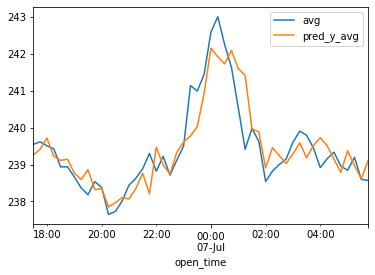

In [60]:
df_testing_model_results[[
#                           'high','pred_y_high', 
#                           'low','pred_y_low',
                          'avg','pred_y_avg'
                        ]][150:200].plot()

In [61]:
df_testing_model_results['high_diff_prec'] = 100 * (df_testing_model_results['pred_y_high'] - df_testing_model_results['y_high'])/df_testing_model_results['y_high']

In [62]:
df_testing_model_results['low_diff_prec'] = 100 * (df_testing_model_results['pred_y_low'] - df_testing_model_results['y_low'])/df_testing_model_results['y_low']

<AxesSubplot:>

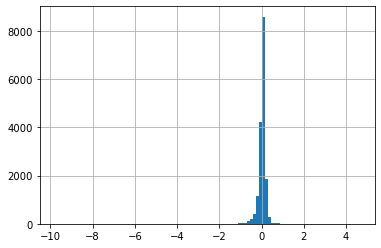

In [63]:
df_testing_model_results['high_diff_prec'].hist(bins =100)

In [64]:
df_testing_model_results[['high_diff_prec','low_diff_prec']].describe()

,high_diff_prec,low_diff_prec
count,17000.000000,17000.000000
mean,0.022514,-0.013283
std,0.202948,0.228170
min,-9.788994,-9.380300
25%,-0.030837,-0.107434
50%,0.050209,-0.046360
75%,0.108723,0.038580
max,4.626032,11.976549


In [65]:
pd.DataFrame(100*(df_testing_model_results['high'] - df_testing_model_results['low'])/df_testing_model_results['low']).describe()

,0
count,17000.000000
mean,0.584821
std,0.510629
min,0.029838
25%,0.308154
50%,0.462848
75%,0.702226
max,26.415386


In [66]:
class DecisionMaking:
    """
    A class that takes pre-trained models and product the next predicted values
    
    list_to_add_unit_hour - list of rolling averages to add in the unit of hour, e.g.
                                list_to_add_unit_hour = [1, 2, 4] , will produce RAs of
                                1H, 2H, 4H (window calculated by dividing by the index_unit)

    index_unit - unit of index (whatever was used in the grouper), e.g. '15min' (takes minutes)


    """
    
    def __init__(self, columns_to_norm, base, list_to_add_unit_hour, index_unit, model_avg, model_high, model_low):
        
        self.columns_to_norm = columns_to_norm
        self.base = base
        self.list_to_add_unit_hour = list_to_add_unit_hour
        self.index_unit = index_unit
        
        self.model_avg  = model_avg
        self.model_high = model_high
        self.model_low  = model_low
        
        assert base not in columns_to_norm, "base should not be in the list of columns, as it will be dividing by 0"
    
    def get_raw_data(self, df):
        """
        raw 1 minute df
        """
        assert df.index.dtype == '<M8[ns]', "Index should be time"
        self.raw_1min_df = df.sort_index(ascending=True).copy(deep=True)
        
        return None
    
    def window_groupby(self, freq, agg_grouping, return_results=False):
        
        """
        return_results to see the table returned, otherwise, save at: self.df_windowed
        """
        
        df=self.raw_1min_df.copy(deep=True)
        grouper_key = self.raw_1min_df.index.name
        assert grouper_key != None, "no grouper key"
        
        df_temp = df.reset_index().groupby(pd.Grouper(key=grouper_key, freq=freq)).agg(agg_grouping)
        if 'open_time' in agg_grouping.keys():
            df_temp.columns = [open_time_refine(col) for col in df_temp.columns]

        df_temp['avg'] = df_temp['quote_asset_volume']/df_temp['volume']
        df_temp['avg'] = df_temp['avg'].fillna(method='ffill')  ## when volume is 0
        
        if return_results:
            return df_temp
            
        else:
            self.df_windowed = df_temp.copy(deep=True)
            return None


    
    def add_rolling_averges(self, return_results=False):
        """
        INPUT:
        return_results - boolean, defult False
        
        OUTPUT:
        (if return_results = True), dataframe with added rolling averages
        (else, save at self.df_wind_ra)
        """

        df_temp = self.df_windowed.copy(deep=True)

        rows = float(self.index_unit.replace('min',''))/60

        for ra in self.list_to_add_unit_hour:

            df_temp['ra_{x}H'.format(x=ra)] = df_temp['avg'].rolling(window=int(ra/rows)).mean()

        if return_results:
            print(".dropna(axis=0) not applied here")
            return df_temp
            
        else:
            self.df_wind_ra = df_temp.dropna(axis=0).copy(deep=True)
            return None


    
    def normalising_data(self, return_results=False):
        """
        INPUT:
        return_results - boolean, defult False

        OUTPUT:
        (if return_results = True), normalised dataframe
        (else, save at self.df_normalised_input)
        """
        
        df_temp = self.df_wind_ra.copy(deep=True)

        for col in self.columns_to_norm:
            df_temp[col] = 100 * ((df_temp[col].astype(np.float)/df_temp[self.base]) - 1)

        if return_results:
            return df_temp
            
        else:
            self.df_normalised_input = df_temp.copy(deep=True)
            return None
        
    def _return_predicted_vales(self, pred, base_value):
        final_value = (1.0 + pred/100) * base_value
        return final_value
    
    def get_predictions(self):
        """
        return predicted: average, low, and high from the models
        """
        y_pred_avg_decision = pipeline_xgb_avg_rel.predict(self.df_normalised_input[self.columns_to_norm].values)
        y_pred_low_decision = pipeline_xgb_low.predict(self.df_normalised_input[self.columns_to_norm].values)
        y_pred_high_decision = pipeline_xgb_high.predict(self.df_normalised_input[self.columns_to_norm].values)

        y_pred_unscaled_avg = self._return_predicted_vales(y_pred_avg_decision[0], self.df_normalised_input[self.base].values[0])
        y_pred_unscaled_low = self._return_predicted_vales(y_pred_low_decision[0], self.df_normalised_input[self.base].values[0])
        y_pred_unscaled_high = self._return_predicted_vales(y_pred_high_decision[0], self.df_normalised_input[self.base].values[0])
            
        return {'pred_avg':y_pred_unscaled_avg,
                'pred_low':y_pred_unscaled_low,
                'pred_high':y_pred_unscaled_high}

In [67]:
class TradingBot:
    def __init__(self, usd_wallet, coin_wallet, maker_fee=0.1, taker_fee=0.2):
        """should alway pay the maker fee (fee in the unit of percentage)"""
        self.usd_wallet = usd_wallet
        self.coin_wallet = coin_wallet
        
        ## maybe add floating position here? self.usd_float, self.crypto_float 
        ## what happens if trading multiple crypto? (they are all from the same wallet)
        
        self.maker_fee = maker_fee
        self.taker_fee = taker_fee
 
        
        self.next_action = 'open_buy_position'  ## can be from {'open_buy_position', 'open_sell_position',
                                                ##              'close_buy_position', 'close_sell_position'}
        
        self.open_order = False # True means currently there is a buy order; to buy crypto using USD
        self.current_low = None  ## will be compared to lows
        self.current_high = None  ## will be compared to highs
        self.pred_low = None
        self.pred_high = None
        
        self.trade_log = [{"time_of_event" : datetime.now(),  ## if back testing, now() shoud be the max time 
                          "event_name"    : "initialisation",
                          "usd_wallet"    : self.usd_wallet, 
                          "coin_wallet"   : self.coin_wallet,
                          "next_action"   : self.next_action,
                           "open_order"   : self.open_order,
                           "pred_low"     : self.pred_low,
                           "pred_high"    : self.pred_high,
                           "true_low"     : self.current_low,
                           "true_high"    : self.current_high
                         }]

    def get_log(self):
        return self.trade_log
    
    def _add_to_log(self, time, event_name, usd_wallet, coin_wallet, next_action):
        self.trade_log.append(
                         {"time_of_event" : time,  ## if back testing, now() shoud be the max time 
                          "event_name"    : event_name,
                          "usd_wallet"    : usd_wallet, 
                          "coin_wallet"   : coin_wallet,
                          "next_action"   : next_action,
                          "open_order"    : self.open_order,
                          "pred_low"     : self.pred_low,
                          "pred_high"    : self.pred_high,
                          "true_low"     : self.current_low,
                          "true_high"    : self.current_high
        })
        
        return None

    def _open_buy_position(self, pred_low):
        self.buy_position = pred_low  ## open a position on the low price, can make adjustments here
        self.open_order = True
        self.next_action = "close_buy_position"
        
        self._add_to_log(self.time,
                         "open_buy_position",
                         self.usd_wallet,
                         self.coin_wallet,
                         self.next_action
                        )
        
        return None 
    
    def _execute_buy_position(self, true_low):
        if true_low < self.buy_position:
            
            self.open_order = False
            self.coin_wallet = self.coin_wallet + float(self.usd_wallet / self.buy_position) * (100 - self.taker_fee)/100
            self.usd_wallet = self.usd_wallet - self.usd_wallet ## (second one should be actual usd spent)
            self.next_action = "open_sell_position"
            
            self._add_to_log(self.time, 
                             "close_buy_position",
                             self.usd_wallet,
                             self.coin_wallet,
                             self.next_action
                            )
            return None
            
        else:
            self._add_to_log(self.time,
                             "waiting_to_close_buy_position",
                             self.usd_wallet,
                             self.coin_wallet,
                             self.next_action
                            )
            return None
            
    
    def _open_sell_position(self, pred_high):
        self.sell_position = pred_high
        self.open_order = True
        self.next_action = "close_sell_position"   
        
        self._add_to_log(self.time, 
                         "open_sell_position",
                         self.usd_wallet,
                         self.coin_wallet,
                         self.next_action
                        )
        
        return None
    
    
    def _execute_sell_position(self, true_high):
        if true_high > self.sell_position:
            self.open_order = False
            
            self.usd_wallet = self.usd_wallet + self.sell_position * self.coin_wallet * (100 - self.taker_fee)/100
            self.coin_wallet = self.coin_wallet - self.coin_wallet

            self.next_action = "open_buy_position"
            self._add_to_log(self.time,
                             "close_sell_position",
                             self.usd_wallet,
                             self.coin_wallet,
                             self.next_action
                            )
            return None
    
        else:
            self._add_to_log(self.time, 
                             "waiting_to_close_sell_position",
                             self.usd_wallet,
                             self.coin_wallet,
                             self.next_action
                            )
            return None
    
    def cancel_position(self):
        self.open_order = False
        if 
        self.next_action = 'open_buy_position'

        self._add_to_log(self.time, 
                             "cancel_trade",
                             self.usd_wallet,
                             self.coin_wallet,
                             self.next_action
                            )
        
        return None
    
    def trading(self, current_low, current_high, time, input_pred_low=None, input_pred_high=None, skip_trade=False):
        self.time = time
        self.current_low = current_low
        self.current_high = current_high
        
        assert self.usd_wallet + self.coin_wallet > 0 , "must have money"
        
        if skip_trade and self.open_order == False:
            self._add_to_log(self.time, 
                             "unfavourable conditions, waiting",
                             self.usd_wallet,
                             self.coin_wallet,
                             self.next_action
                            )
        
        
        else:
            if self.open_order == False: ## no open order, looking to open a position
                if self.next_action == 'open_buy_position':
                    self.pred_low = input_pred_low
                    self._open_buy_position(self.pred_low)  ## opened a buy position at pred_low price

                elif self.next_action == 'open_sell_position':
                    self.pred_high = input_pred_high
                    self._open_sell_position(self.pred_high)

                else:
                    assert False, "self.next_action is {action} when there is NO Open Order, this should not happen".format(action=self.next_action)

            else: ## has open order, looking to sell
                assert self.open_order == True, "has to be True here (boolean), got: {value}".format(value=self.open_order)

                if self.next_action == 'close_buy_position':
                    self._execute_buy_position(current_low)

                elif self.next_action == 'close_sell_position':
                    self._execute_sell_position(current_high)

                else:
                    assert False, "self.next_action is {action} when there is an Open Order, this should not happen".format(action=self.next_action)

SyntaxError: invalid syntax (<ipython-input-67-a5cd62f7b008>, line 136)

In [68]:
data_4H = pd.DataFrame([], columns = ['open','high','low','close','volume','quote_asset_volume'])
data_4H.index.name = 'open_time'

In [69]:
decide = DecisionMaking(columns_to_norm = columns_to_norm,
                        base = base,
                        list_to_add_unit_hour = [1,2,4],
                        index_unit = '15min',
                        model_avg = pipeline_xgb_avg_rel,
                        model_high = pipeline_xgb_low,
                        model_low = pipeline_xgb_high)

In [70]:
def run_decision(decision_class, df_past_4hours):
    decision_class.get_raw_data(df_past_4hours)
    decision_class.window_groupby(freq='15min', 
                      agg_grouping={'open': 'first',
                                     'high': 'max',
                                     'low': 'min',
                                     'close': 'last',
                                     'volume': 'sum',
                                     'quote_asset_volume': 'sum',
                                     'open_time': ['min', 'max', 'count']}
                     )
    decision_class.add_rolling_averges()
    decision_class.normalising_data()
    
#     display(decision_class.df_normalised_input[['open_time_max']])
    return (decision_class.get_predictions() )

In [71]:
min_df = df_ETHUSD_1min.iloc[0].name

In [72]:
max_df = df_ETHUSD_1min.iloc[-1].name

In [73]:
df_ETHUSD_1min_reindex = df_ETHUSD_1min.reindex(pd.date_range(start=min_df, end=max_df, freq='min')).copy(deep=True)

In [74]:
df_ETHUSD_1min_reindex = df_ETHUSD_1min_reindex.fillna(method='ffill')

In [75]:
df_ETHUSD_1min_reindex.index.name = 'open_time'

In [76]:
df_base = df_ETHUSD_1min_reindex[df_ETHUSD_1min_reindex.index >= '2020-12-01'][:239]  ## + 12 to make sure it starts on the multiples of quarter minutes
df_continue = df_ETHUSD_1min_reindex[df_ETHUSD_1min_reindex.index >= '2020-12-01'][239:]

In [78]:

history_log = {}
n = 0
to_skip_trade = False

## fee of 0.4%
downward_adjustment = 1  ## unit percent
dif_high_low = 3 ## unit percent
order_high_from_low = 1.5 ## unit percent, at least 0.4

eth_bot1 = TradingBot(100, 0)
next_event = eth_bot1.get_log()[-1]['next_action'] 

prediction_log = []

number_of_window = 0

for k, row in df_continue.iterrows():
    """4H of data"""
    row_append =pd.Series( {'open' :row['open'],
                          'high' :row['high'],
                          'low'  :row['low'],
                          'close':row['close'],
                          'volume':row['volume'],
                          'quote_asset_volume':row['quote_asset_volume']
                       }, 
                     name = row.name
                     )

    df_base = df_base.append(row_append, ignore_index=False)
    
    if n%15 == 0:
        for_log = run_decision(decide, df_base)
        if 100 * (for_log['pred_high']/for_log['pred_low'] -1) > dif_high_low:
            number_of_window += 1

    if n%15 == 0 and next_event in ['open_sell_position','open_buy_position']:
        
        predicted_values = run_decision(decide, df_base)
        low_price_position = predicted_values['pred_low'] * ((100-downward_adjustment)/100)
        high_price_position = low_price_position * (100 + order_high_from_low)/100
        
        prediction_log.append((row.name, predicted_values))

#         print(100 * (predicted_values['pred_high']/predicted_values['pred_low'] -1))
        
        if 100 * (predicted_values['pred_high']/predicted_values['pred_low'] -1) > dif_high_low:
            to_skip_trade = True

        else:
            to_skip_trade = False
            print('finally', to_skip_trade, row.name)

    df_base= df_base[1:]
    n+=1
    
    if n%(60*24) == 0:
        print(row.name, 
              eth_bot1.usd_wallet, 
              eth_bot1.coin_wallet,
              eth_bot1.coin_wallet * row['close'],
              high_price_position, 
              high_price_position * eth_bot1.coin_wallet,
              'window: ' , number_of_window)

        
    else:
        pass
    
    eth_bot1.trading(current_low=row['low'], 
                     current_high=row['high'],
                     time=row.name,
                     input_pred_low= low_price_position, 
                     input_pred_high= high_price_position,
                     skip_trade=to_skip_trade)
    
    next_event = eth_bot1.get_log()[-1]['next_action'] 
    
    
#     if row.name == pd.to_datetime(df_continue.iloc[-1:].index.values)[0]:
#         break
    if n > 24*60*8:
        break

NameError: name 'TradingBot' is not defined

In [ ]:
eth_bot1.usd_wallet

In [79]:
eth_bot1.coin_wallet

NameError: name 'eth_bot1' is not defined

In [80]:
trade_bot_log = pd.DataFrame(eth_bot1.get_log())

NameError: name 'eth_bot1' is not defined

In [81]:
trade_bot_log['event_name'].unique()

NameError: name 'trade_bot_log' is not defined

In [82]:
trade_bot_log[trade_bot_log['event_name'].apply(lambda x: 'waiting' not in x)].head(60)

NameError: name 'trade_bot_log' is not defined

<AxesSubplot:xlabel='open_time'>

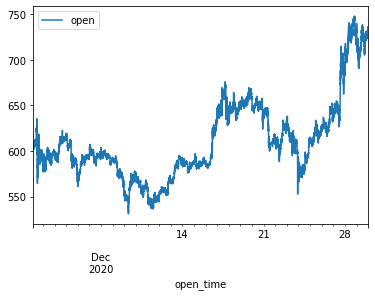

In [83]:
df_continue[['open']].plot()